## [ Fastcampus Mini-project ] 
### House Sales in King County, USA (Predict house price using Linear regression) - 
### 집값에 영향을 미치는 요인을 통해 King County의 집값을 예측해보자.
### 팀 : R까기(김나래, 박경호, 하정철) 
### 발표일자 : 2017 - 08 - 09  

---
### [ 최종 모형 ]    
### final = lm(log(price) ~ grade + log(sqft_living) + factor(dummy.median), data = result)
### Adjusted R-squared : 0.800
### 'zipcode'를 이용한 파생변수를 만들어서 집값을 예측

---
### [ Dataset  :  kc_house_data.xlsx ] 
### 종속변수  :  1개( price )
### 독립변수  :  17개( id, date, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, grade	
###                     sqft_above,	sqft_basement, yr_built, yr_renovated, sqft_living15, sqft_lot15 )

---
### [ 사용 모델 ]  Multiple Linear Regression ( 다중선형회귀분석)
### [ 진행 과정 ] 
### 1. EDA
###    - 데이터 유형 살펴보기
###    - train / test 셋 분류
###    - 종속변수와 독립변수 상관관계 분석
### 2. 데이터 전처리
###    - ggmap 라이브러리를 통한 시각화
###    - zipcode를 통한 파생변수 생성
### 3. 회귀분석
### 4. 모델 검증 및 결과 

In [ ]:
library = c("dplyr","GGally","readxl","ggplot2","ggmap","data.table",
            "R.utils","DT","maps","rJava","corrplot","caret","IRdisplay")
for(i in 1:length(library)){library(library[i], character.only = T)}

In [ ]:
House = readxl::read_excel("fs/house/kc_house.xlsx",
                           sheet = "data",
                           col_names = TRUE)
House$date<-(substr(House$date, 1, 8))
House$date = as.numeric(House$date)
House$per.price = House$price / House$sqft_living

---
# 1. EDA

In [5]:
# summary(House)
# View(House)
# str(House)
colSums(is.na(House))
# 위 3단계 과정은 한 번쯤 다 보셨을 테니 생략
# colSums()를 통해 Missing Value 확인

id          date         price      bedrooms     bathrooms 
            0             0             0             0             0 
  sqft_living      sqft_lot        floors    waterfront          view 
            0             0             0             0             0 
    condition         grade    sqft_above sqft_basement      yr_built 
            0             0             0             0             0 
 yr_renovated       zipcode           lat          long sqft_living15 
            0             0             0             0             0 
   sqft_lot15     per.price 
            0             0

In [4]:
# train 70% / test 30%
# trian 을 통해 모형을 만들고, test를 통해 해당 모형 검증
set.seed(14)
ratio = sample(1:nrow(House), size = 0.30*nrow(House))
test = House[-ratio,] #Test dataset 30% of total
train = House[ratio,] #Train dataset 70% of total

### 상관관계 분석

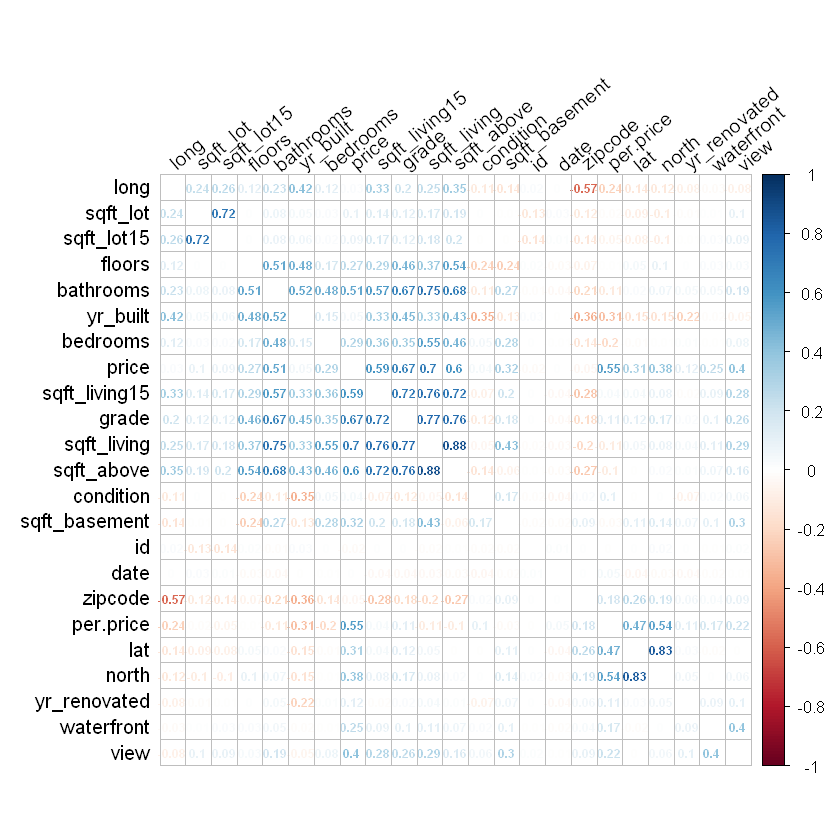

In [31]:
# 종속변수(price)에 영향을 미치는 변수를 찾기 위해 corrplot을 활용하여 분석한 결과, 아래와 같은 결과를 얻었음. 

train.num <- cor(train) ## House_num 생성 후 상관관계 분석치 할당
train.num = round(train.num, 3) ## 소수점 셋째자리까지 출력 
corrplot::corrplot(train.num, 
                   method = "number", 
                   shade.col = NA, 
                   tl.col = "black", 
                   tl.srt = 40,
                   order = "hclust",
                   diag = FALSE,
                   number.cex = 0.6)

#### sample에 따라서 상관계수가 약간은 다를 수 있어요!
#### 결과 : 5개의 변수가 price와 높은 상관관계를 보여줌
#### price ~ sqft_living     : 0.698
#### price ~ grade             : 0.662
#### price ~ sqft_above    : 0.602
#### price ~ sqft_living15 : 0.584
#### price ~ bathrooms    : 0.518
---
#### price ~ view                   : 0.405
#### price ~ sqft_basement : 0.323
#### price ~ bedrooms         : 0.310
#### price ~ waterfront         : 0.266
#### price ~ floors                 : 0.257
#### price ~ yr_renovate      : 0.126
#### price ~ sqft_lot             : 0.0897
#### price ~ sqft_lot15         : 0.0824
#### price ~ yr_built             : 0.054
#### price ~ condition          : 0.0364

In [16]:
analysis = train %>% 
  select(price, zipcode, sqft_living, grade, bathrooms, bedrooms, lat, long)

---
### 양의 상관관계를 보이는 변수들 중 잠재적 세입자가 집을 보러왔을 때,
### 어떤 조건을 가장 신경쓰며 집을 볼 지에 대해 고민해보았고, 그 요소들을 변수로 채택.  

### waterfront의 경우 해안뷰가 집값에 영향을 미칠 것이라고 생각했으나,
### 전체 데이터 중 163개의 데이터만이 해안뷰를 가지고 있으며 
### google맵에 시각화 해보니 전역에 퍼져있기 때문에 종속변수로 적합하지 않다고 생각. 

---
## 그렇다면? 
### 어떤 요소가 집값에 가장 많은 영향력을 가질까? => 지리적 요소
### 전체 데이터를 구글맵에 시각화

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=47.4,-122.3&zoom=9&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Warning message:
"Removed 4 rows containing non-finite values (stat_density2d)."

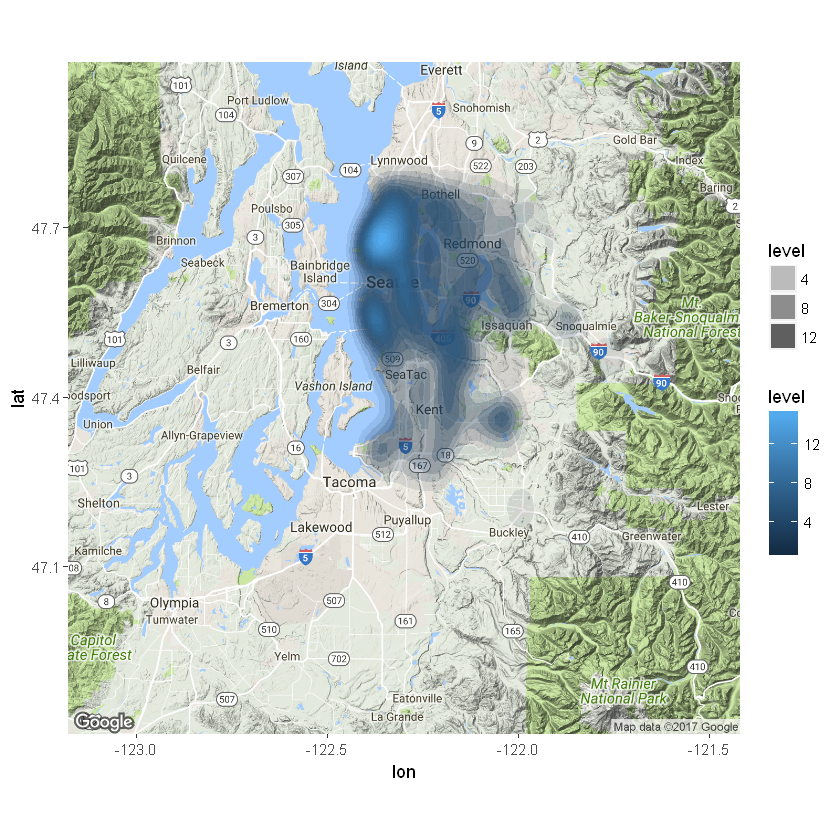

In [6]:
KingCounty.all = ggmap::get_map(location = c(lon=-122.3, lat=47.4),
                            zoom = 9)
KingCounty.all.1 = ggmap(KingCounty.all) + stat_density_2d(data = train, aes(x = long, y = lat, fill=..level.., alpha=..level..), geom = "polygon", size = 1, bins= 20)
KingCounty.all.1

### 서울을 생각했을 때 강남과 강북은 분명히 집값 차이가 존재한다. 
### 이에 따라 'King County 지역에서도 남북간의 집 값 차이가 있지 않을까?' 라는 생각에 
### 위도 중간 값을 기준으로 남, 북 집값의 평균치를 구해본 결과 아래와 같은 결과가 나왔다. 

Warning message:
"Removed 3 rows containing missing values (geom_point)."Warning message:
"Removed 1 rows containing missing values (geom_point)."

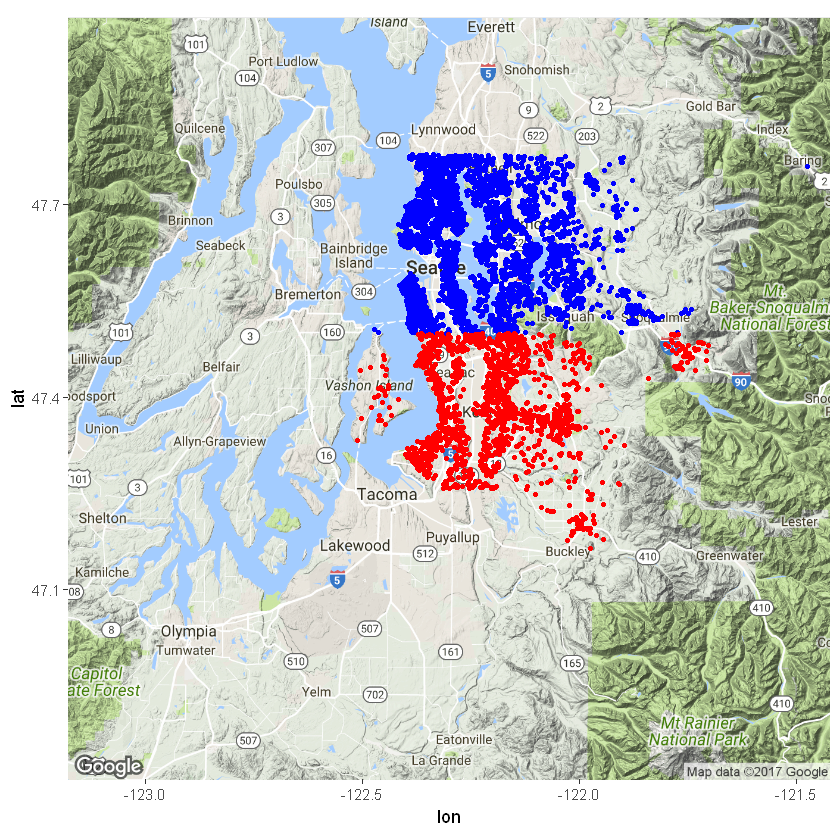

In [8]:
## 위도 47.5를 기준으로 남 / 북으로 데이터를 구분
train$north = ifelse(train$lat >= 47.5 ,1 ,0)
north = train %>% 
  filter(north == 1)
south = train %>% 
  filter(north == 0)

KingCounty.all.2 = ggmap(KingCounty.all) + geom_point(data = north, aes(x = long, y = lat),
color = "blue", size = 1) + geom_point(data = south, aes(x = long, y = lat), color = "red", size = 1)
KingCounty.all.2

### 남과 북 가격 비교

In [9]:
train %>% 
  select(price, north) %>% 
  group_by(north) %>% 
  summarise(max.price = max(price),
            min.price = min(price),
            mean.price = mean(price),
            median.price = median(price),
            n = n())

north max.price min.price mean.price median.price n   
1 0     1950000   75000     330416.6   299125       1970
2 1     6885000   80000     626510.5   535000       4513

---
# 2. 데이터 전처리

## zipcode 를 통해 grouping 해서 파생변수를 만들어보자!
### 미국의 zipcode는 5자리로 구성되어 있으며, 주, 카운티, 도시 단위의 광범위한 지역을 나타내준다.
### 미국인들에게는 zipcode 자체가 '부와 명예'를 상징한다고 한다. (출처:LA중앙일보)
### 그렇다면 zipcode(각 도시)마다 단위면적 당 가격(per.price)이 비슷한 가격대를 형성하고 있지 않을까?

In [23]:
analysis$per.price = analysis$price / analysis$sqft_living # per.price 변수 생성
# zipcode 별로 grouping하여 최대, 최소, 평균, 중위수, 데이터 개수 계산
zipcode.price = analysis %>% 
  select(zipcode, per.price) %>% 
  group_by(zipcode) %>%  
  summarise(max.price = max(per.price),
            min.price = min(per.price),
            mean.price = mean(per.price),
            median.price = median(per.price),
            n = n())

nrow(zipcode.price) # zipcode는 총 70개
head(zipcode.price) # 각 zipcode별로 34 ~ 430의 데이터들이 존재

[1] 70

zipcode max.price min.price mean.price median.price n  
1 98001   395.2381   88.69863 151.1300   146.7005     249
2 98002   247.4747   90.75342 150.3842   146.3859     140
3 98003   258.1197   88.15029 159.7440   157.3427     197
4 98004   789.4737  258.27815 480.1124   459.4059     205
5 98005   482.4561  148.75099 315.3288   316.2252     119
6 98006   750.7508  159.45946 296.9763   286.4056     344

In [27]:
# zipcode별 평균 - 중위수 차이 계산
zipcode.price$dif.price = round(zipcode.price$mean.price - zipcode.price$median.price, digits = 2)
zipcode.price = zipcode.price[order(zipcode.price$dif.price),]
head(zipcode.price, n = 5)
tail(zipcode.price, n = 5)

zipcode max.price min.price mean.price median.price n   dif.price
1 98005   482.4561  148.7510  315.3288   316.2252     119 -0.90    
2 98053   701.4493  104.3632  268.3259   268.7576     274 -0.43    
3 98007   438.1443  168.4783  292.9529   293.3009     102 -0.35    
4 98027   493.3586  126.3333  251.4904   250.9434     297  0.55    
5 98029   406.6667  190.3974  273.7801   271.5395     216  2.24

zipcode max.price min.price mean.price median.price n   dif.price
1 98118   774.1333   89.52802 265.2918   242.2352     358 23.06    
2 98199   750.0000  221.46893 383.0593   359.5971     212 23.46    
3 98010   674.5763  106.01266 219.8420   196.1905      73 23.65    
4 98146   792.6829   87.64706 228.4912   200.2189     206 28.27    
5 98070   706.5217  132.23140 277.3688   242.8235      77 34.55

### 98070(배숀셤) => 34.55
### 98146(화이트센터) => 28.27 
### 나머지 -0.90 ~ 23.65로 골고루 분포
### 'zipcode별로 평당 가격이 큰 차이를 보이는 집은 별로 없다' 라고 생각

In [29]:
## 100단위로 dummy변수 대입
zipcode.price$median.price = round(zipcode.price$median.price)
zipcode.price$dummy.median = as.numeric(substr(zipcode.price$median.price,1,1))*100
head(zipcode.price)

zipcode max.price min.price mean.price median.price n   dif.price
1 98005   482.4561  148.75099 315.3288   316          119 -0.90    
2 98053   701.4493  104.36321 268.3259   269          274 -0.43    
3 98007   438.1443  168.47826 292.9529   293          102 -0.35    
4 98027   493.3586  126.33333 251.4904   251          297  0.55    
5 98029   406.6667  190.39735 273.7801   272          216  2.24    
6 98003   258.1197   88.15029 159.7440   157          197  2.40    
  dummy.median
1 300         
2 200         
3 200         
4 200         
5 200         
6 100

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=47.4,-122.3&zoom=9&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Warning message:
"Removed 13 rows containing missing values (geom_point)."

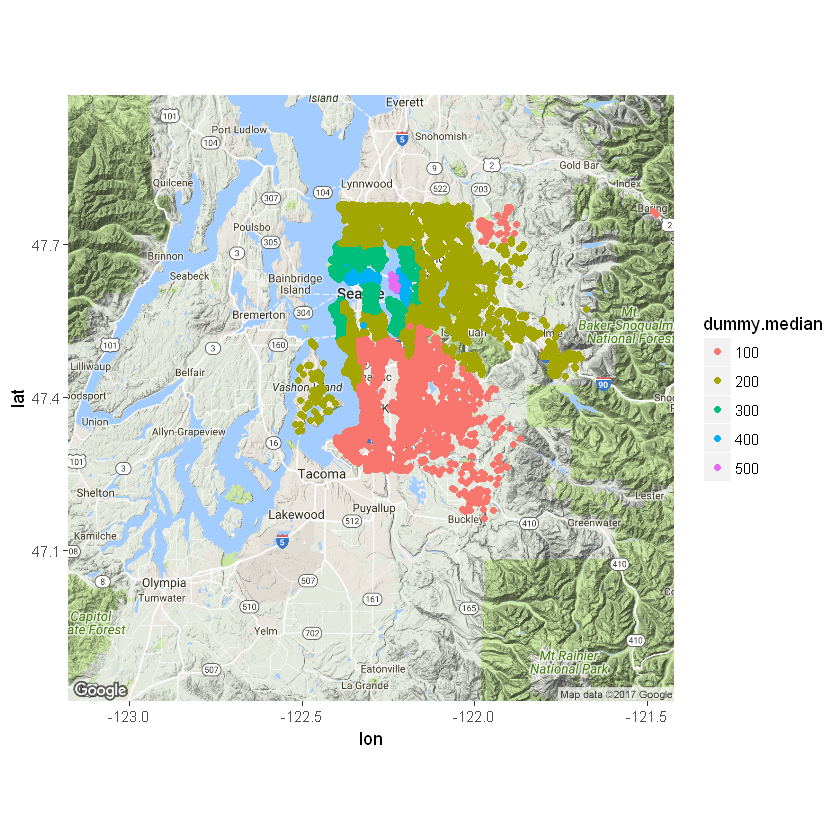

In [30]:
## zipcode.price에서 zipcode, dummy.median를 추출하여 mg데이터 생성
mg = zipcode.price %>% 
  select(zipcode, dummy.median)

## analysis와 mg를 zipcode(PK)기준으로 left outer join 
analysis1 = merge(analysis, mg, by = "zipcode", all.x=TRUE)
analysis1$dummy.median = as.factor(analysis1$dummy.median)

## 구글맵에 시각화
KingCounty = ggmap::get_map(location = c(lon=-122.3, lat=47.4),
                            zoom = 9)
KingCounty1 = ggmap(KingCounty) + geom_point(data = analysis1, aes(x = long, y = lat, colour = dummy.median))
KingCounty1

### 남,북 간에 가격 차이가 존재한다는 것을 확인 했으니
### 단위 면적 가격이 200이지만 상대적으로 가격대가 높은 지역 or 낮은 지역과 접해있는 3곳을 추가로 확인

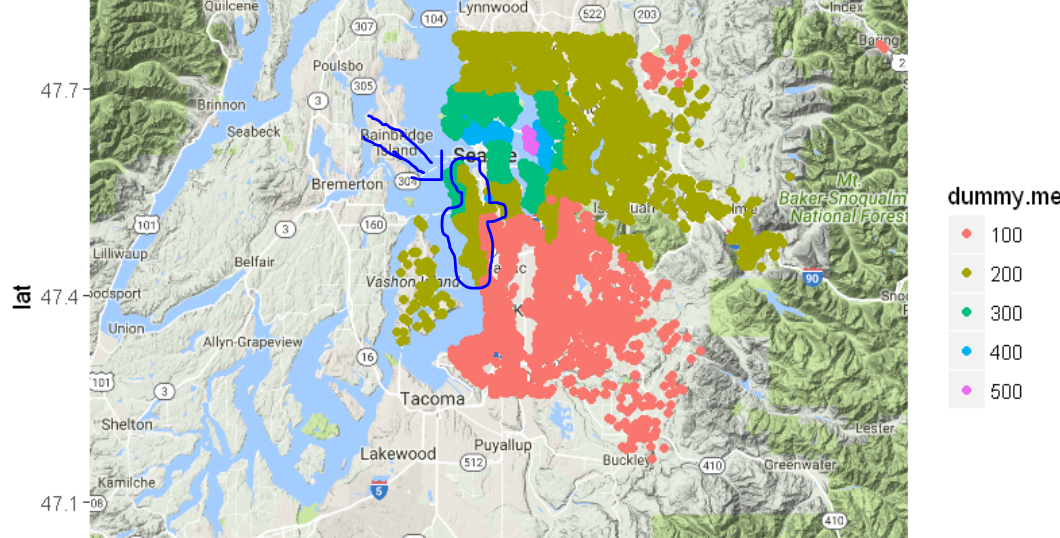

In [9]:
IRdisplay::display_png(file="image/img01.PNG") 

In [40]:
## median.price 가 200~300 사이인 데이터만 추출
zipcode.price1 = zipcode.price %>%
  filter(median.price >= 200 & median.price <300) %>% 
  select(zipcode, median.price)

## 나머지를 구해서 10의자리 계산
zipcode.price1$dummy.median = as.numeric(substr(zipcode.price1$median.price,1,2))%%10
head(zipcode.price1)

zipcode median.price dummy.median
1 98053   269          6           
2 98007   293          9           
3 98027   251          5           
4 98029   272          7           
5 98077   242          4           
6 98011   225          2

Warning message:
"Removed 13 rows containing missing values (geom_point)."

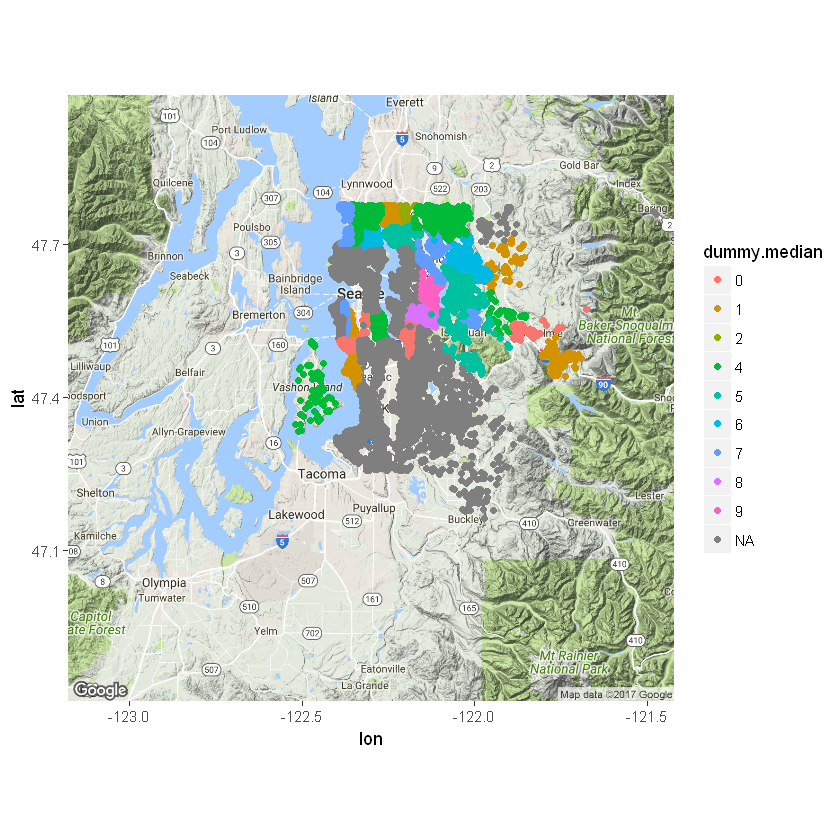

In [42]:
## analysis와 zipcode.price1을 zipcode(PK)기준으로 left outer join 
analysis2 = merge(analysis, zipcode.price1, by = "zipcode", all.x = TRUE)
analysis2$dummy.median = as.factor(analysis2$dummy.median) # factor로 변환

## 구글맵에 시각화
KingCounty2 = ggmap(KingCounty) + geom_point(data = analysis2, aes(x = long, y = lat, colour = dummy.median))
KingCounty2

### 2곳은 200대 초반 / 1곳은 200대 후반 가격대를 형성하고 있다.

In [44]:
## per.price 가 200대인 집들을 시각화한 결과를 바탕으로
## 200 초반대 까지는 100에 
## 200 중반은 200으로
## 200 후반 값을 가지는 8,9는 300에 같이 그룹핑
zipcode.price2 = zipcode.price
zipcode.price2 = within(zipcode.price2,{
  dummy.median = numeric(0)
  dummy.median [ median.price < 220] = 1
  dummy.median [ median.price >= 221 & median.price <= 279 ] = 2
  dummy.median [ median.price >= 280 & median.price <= 399 ] = 3
  dummy.median [ median.price >= 400 & median.price <= 499 ] = 4
  dummy.median [ median.price >= 500 & median.price <= 599 ] = 5
  dummy.median [ median.price >= 600] = 6
})
head(zipcode.price2)

zipcode max.price min.price mean.price median.price n   dif.price
1 98005   482.4561  148.75099 315.3288   316          119 -0.90    
2 98053   701.4493  104.36321 268.3259   269          274 -0.43    
3 98007   438.1443  168.47826 292.9529   293          102 -0.35    
4 98027   493.3586  126.33333 251.4904   251          297  0.55    
5 98029   406.6667  190.39735 273.7801   272          216  2.24    
6 98003   258.1197   88.15029 159.7440   157          197  2.40    
  dummy.median
1 3           
2 2           
3 3           
4 2           
5 2           
6 1

In [71]:
## zipcode.price2로부터 zipcode와 dummy.median을 추출한 mg1 데이터를 만들어 주고
mg1 = zipcode.price2 %>% 
  select(zipcode, dummy.median)
head(mg1)
##analysis와 mg1를 zipcode(PK)기준으로 left outer join 
analysis3 = merge(analysis, mg1, by = "zipcode", all.x=TRUE)
analysis3$dummy.median = as.factor(analysis3$dummy.median) # dummy.median을 factor로 변환

zipcode dummy.median
1 98005   3           
2 98053   2           
3 98007   3           
4 98027   2           
5 98029   2           
6 98003   1

Warning message:
"Removed 13 rows containing missing values (geom_point)."

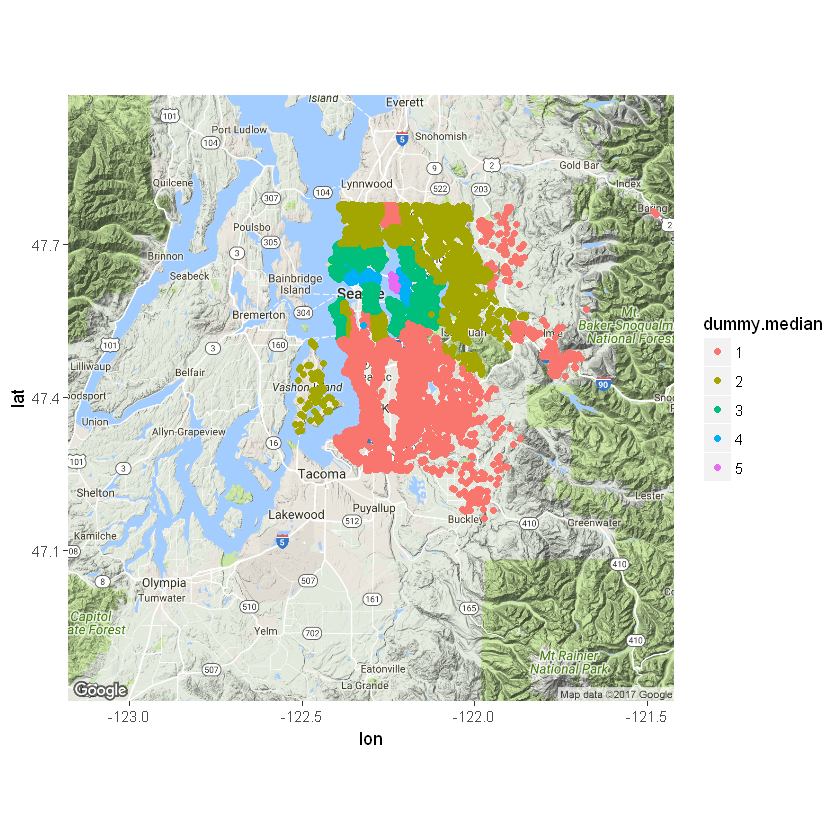

In [47]:
## 구글맵에 시각화
KingCounty3 = ggmap(KingCounty) + geom_point(data = analysis3, aes(x = long, y = lat, colour = dummy.median))
KingCounty3

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=47.6,-122.3&zoom=11&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Warning message:
"Removed 6156 rows containing missing values (geom_point)."

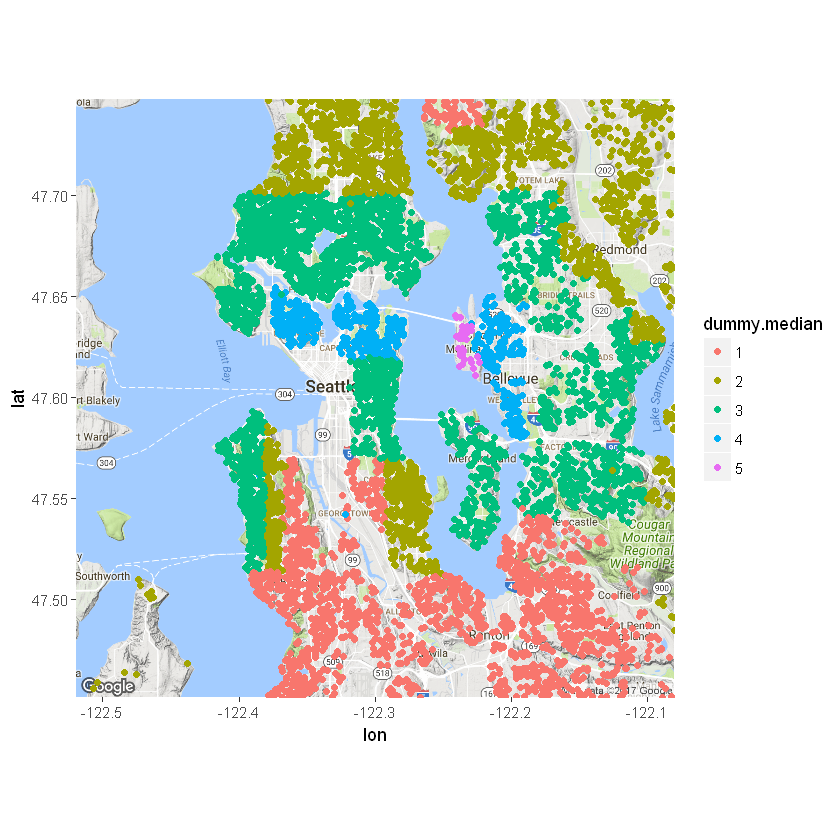

In [49]:
# 비싼 지역을 확대해볼까요?
KingCounty.zoom = ggmap::get_map(location = c(lon=-122.3, lat=47.6), zoom=11)
KingCounty4 = ggmap(KingCounty.zoom) + geom_point(data = analysis3, aes(x = long,  y = lat, colour = dummy.median))
KingCounty4

---
# 3. 회귀분석

In [51]:
result = analysis3 %>% 
  select(price, bedrooms, bathrooms, grade, sqft_living, dummy.median)

In [53]:
## price와 sqft_living 은 숫자 단위가 크므로 log를 취함
model.1 = lm(log(price) ~ bedrooms + bathrooms + grade + log(sqft_living) + factor(dummy.median), data = result)
summary(model.1)


Call:
lm(formula = log(price) ~ bedrooms + bathrooms + grade + log(sqft_living) + 
    factor(dummy.median), data = result)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.2347 -0.1461 -0.0104  0.1324  1.3739 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            7.671678   0.051588 148.711   <2e-16 ***
bedrooms              -0.024589   0.002639  -9.318   <2e-16 ***
bathrooms              0.010022   0.004001   2.505   0.0123 *  
grade                  0.113577   0.002642  42.995   <2e-16 ***
log(sqft_living)       0.565491   0.008952  63.167   <2e-16 ***
factor(dummy.median)2  0.351462   0.004677  75.147   <2e-16 ***
factor(dummy.median)3  0.597608   0.004919 121.500   <2e-16 ***
factor(dummy.median)4  0.851582   0.009680  87.975   <2e-16 ***
factor(dummy.median)5  1.169356   0.039862  29.335   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2341 on 15121 degrees of freedo

### 1단계 : 회귀모형은 통계적으로 타당한가?
#### 귀무가설 : 회귀모형은 타당하지 않다.
#### 대립가설 : 회귀모형은 타당하다.
    F-statistic:  7645 on 8 and 15121 DF,  p-value: < 2.2e-16

### 1단계 결론 : 대립가설(회귀모형은 통계적으로 타당하다.)

---
### 2단계 : 독립변수는 종속변수에 영향을 주는가?
#### 귀무가설 : 독립변수는 종속변수에게 영향을 주지 않는다.
#### 대립가설 : 독립변수는 종속변수에게 영향을 준다.
                           Estimate Std. Error t value Pr(>|t|)    
    (Intercept)            7.671678   0.051588 148.711   <2e-16 ***
    bedrooms              -0.024589   0.002639  -9.318   <2e-16 ***
    bathrooms              0.010022   0.004001   2.505   0.0123 *  
    grade                  0.113577   0.002642  42.995   <2e-16 ***
    log(sqft_living)       0.565491   0.008952  63.167   <2e-16 ***
    factor(dummy.median)2  0.351462   0.004677  75.147   <2e-16 ***
    factor(dummy.median)3  0.597608   0.004919 121.500   <2e-16 ***
    factor(dummy.median)4  0.851582   0.009680  87.975   <2e-16 ***
    factor(dummy.median)5  1.169356   0.039862  29.335   <2e-16 ***

### 2단계 결론 : 유의확률이 0.000이므로 유의수준 0.05에서 독립변수는 종속변수에게 (통계적으로 유의한) 영향을 준다.

In [56]:
lm.beta::lm.beta(model.1)


Call:
lm(formula = log(price) ~ bedrooms + bathrooms + grade + log(sqft_living) + 
    factor(dummy.median), data = result)

Standardized Coefficients::
          (Intercept)              bedrooms             bathrooms 
           0.00000000           -0.04411214            0.01467268 
                grade      log(sqft_living) factor(dummy.median)2 
           0.25455110            0.45830799            0.30667001 
factor(dummy.median)3 factor(dummy.median)4 factor(dummy.median)5 
           0.49628629            0.33452695            0.10689101 


### 독립변수의 영향력을 비교해보니 두 변수의 영향력은 미비함
    bedrooms  : -0.044
    bathrooms : 0.014
### 두 변수를 제외한 모델 생성

In [61]:
model.2 = lm(log(price) ~ grade + log(sqft_living) + factor(dummy.median), data = result)
summary(model.2)


Call:
lm(formula = log(price) ~ grade + log(sqft_living) + factor(dummy.median), 
    data = result)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.24680 -0.14653 -0.00978  0.13302  1.40751 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           7.808333   0.039238  199.00   <2e-16 ***
grade                 0.119912   0.002505   47.87   <2e-16 ***
log(sqft_living)      0.532780   0.006780   78.58   <2e-16 ***
factor(dummy.median)2 0.352546   0.004685   75.24   <2e-16 ***
factor(dummy.median)3 0.596922   0.004930  121.07   <2e-16 ***
factor(dummy.median)4 0.852117   0.009705   87.80   <2e-16 ***
factor(dummy.median)5 1.170788   0.039970   29.29   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2347 on 15123 degrees of freedom
Multiple R-squared:  0.8006,	Adjusted R-squared:  0.8005 
F-statistic: 1.012e+04 on 6 and 15123 DF,  p-value: < 2.2e-16


### 1단계 : 회귀모형은 통계적으로 타당한가?  
### 2단계 : 독립변수들은 종속변수에 영향을 주는가? 
### 두 경우를 모두 만족하므로 다중공선성을 확인해보자.

In [64]:
vif(model.2)

GVIF     Df GVIF^(1/(2*Df))
grade                2.390565 1  1.546145       
log(sqft_living)     2.290418 1  1.513413       
factor(dummy.median) 1.079450 4  1.009602

### vif가 10이상인 변수가 없으므로 다중공선성 문제는 없음
### 각 독립변수들이 종속변수에 미치는 영향력은?

In [68]:
lm.beta::lm.beta(model.2)


Call:
lm(formula = log(price) ~ grade + log(sqft_living) + factor(dummy.median), 
    data = result)

Standardized Coefficients::
          (Intercept)                 grade      log(sqft_living) 
            0.0000000             0.2687493             0.4317971 
factor(dummy.median)2 factor(dummy.median)3 factor(dummy.median)4 
            0.3076157             0.4957161             0.3347373 
factor(dummy.median)5 
            0.1070219 


### 최종모형

In [81]:
final = lm(log(price) ~ grade + log(sqft_living) + factor(dummy.median), data = result)

---
# 4. 모델 검증 및 결과 

In [82]:
## test데이터를 불러와 log.price변수를 추가
test = merge(test, mg1, by = "zipcode", all.x=TRUE)
test$log.price = log(test$price)
head(test)

zipcode id         date     price  bedrooms bathrooms sqft_living sqft_lot
1 98001   6306100080 20140909 234950 3        2.0       1430        10850   
2 98001    128500260 20140508 262000 4        2.5       2020         6236   
3 98001   6084600660 20140718 263000 3        2.5       1720         6847   
4 98001   7696600240 20141023 165000 3        1.5       1280         7742   
5 98001   3356402020 20140508 230000 3        1.0       1390        16000   
6 98001   2005950050 20140527 260000 3        2.0       1630         8018   
  floors waterfront ... sqft_basement yr_built yr_renovated lat     long    
1 1      0          ... 0             1994     0            47.2671 -122.233
2 2      0          ... 0             2002     0            47.2796 -122.247
3 2      0          ... 0             1987     0            47.3266 -122.272
4 1      0          ... 0             1973     0            47.3323 -122.276
5 1      0          ... 0             1960     0            47.2898 -122.251
6 1      0          ... 0             2003     0            47.2638 -122.243
  sqft_living15 sqft_lot15 per.price dummy.median log.price
1 1610           8015      164.3007  1            12.36713 
2 1940           5076      129.7030  1            12.47610 
3 1610           7790      152.9070  1            12.47991 
4 1566           7696      128.9062  1            12.01370 
5 1420          10000      165.4676  1            12.34583 
6 1610           8397      159.5092  1            12.46844

In [84]:
## 생성된 모델을 바탕으로 test를 예측
pred = predict(final, 
               newdata = test,
               interval = "predict")
pred = as.data.table(pred)

In [86]:
## pred는 test를 얼마나 예측 했을까?
pred.final = pred 
test.final = test %>% 
  select(price, log.price)

## test의 log.price가 예측 범위 내에 얼마나 존재하는지 확인
## lwr(예측값) <= log.price(실제값) <= upr(예측값)
pred.final = cbind(test.final, pred.final)
pred.final$result = ifelse( (pred.final$lwr <= pred.final$log.price) & (pred.final$log.price <= pred.final$upr) ,1 ,0)
table(pred.final$result)


   0    1 
 311 6172 

In [88]:
(6172 / (6172+311)) * 100

[1] 95.20284

### test data가 생각보다 적합한 모델이 도출된 것 같다.
### 예측범위내에 95%의 데이터가 존재

--- 
# 그 외...
### 잔차 그래프

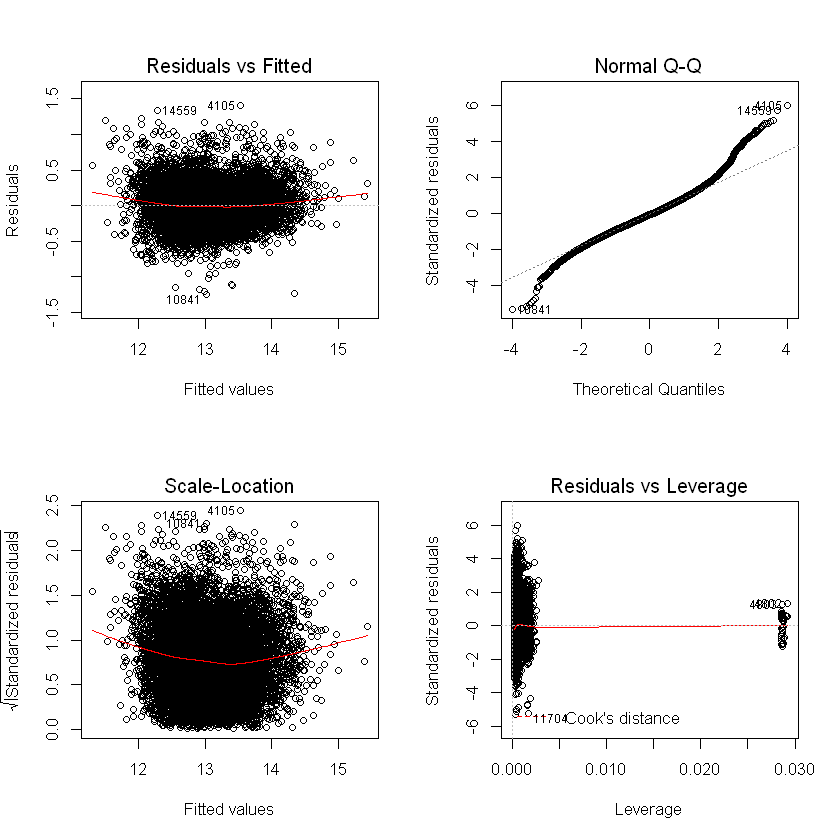

In [90]:
par(mfrow=c(2,2))
plot(model.2)

### 첫 번째 그래프 : 잔차가 0을 중심으로 골고루 퍼져있음
### 두 번째 그래프 : 이상치들에 대한 전처리가 필요할 것 같다...
### 세 번째 그래프 : 표준화 잔차
### 네 번째 그래프 : 오른쪽 끝에 모여 있는 데이터는  per.price가 500이상인 zipcode(98039) => 부자 동네

---
# 소감
## 진행하기에 앞서... 
### kaggle을 살펴보면 kc_house 데이터셋으로 진행된 다양한 사례들이 존재함.
### 1) Decision Tree를 통해 99%의 데이터를 분류하는 모델
### 2) Clustering을 통한 더미 변수생성으로 회귀분석을 진행한 R-Squared = 0.900 모델
---
## 그렇다면 우리는?
### 배운내용을 바탕으로... 패키지 연습도 이것 저것 해볼겸...
### zipcode로 데이터를 분석
### 결론 : 공부가 더 필요하다.